# Imports & basic configuration

In [1]:
try:
    # always cd to the right directory in google colab
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/Colab Notebooks/branch_full/deep_branching"
except:
    pass

import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
from branch import Net
from galerkin import DGMNet
from bsde import BSDENet
import logging

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
import torchaudio
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchaudio version: {torchaudio.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.11.0+cu113
torchaudio version: 0.11.0+cu113
torchvision version: 0.12.0+cu113


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Fri May  6 09:19:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 510.60.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:07:00.0  On |                  N/A |
|  0%   53C    P8    31W / 350W |    305MiB / 12288MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

In [2]:
# performance evaluation for PDE
def compare_performance(
    grid_1d,
    grid_nd,
    grid_with_t,
    t_lo,
    true,
    terminal,
    fname=None,
    debug_mode=False,
    disable_galerkin=False,
    disable_bsde=False,
    disable_branch=False,
    seeds=list(range(10)),
    **kwargs,
):
    x_lo, x_hi = grid_nd.min(), grid_nd.max()
    grid_nd = grid_nd.astype(np.float32)
    grid_with_t = grid_with_t.astype(np.float32)

    fname = f"{fname}_dim_{grid_nd.shape[0]}" if fname is not None else None
    counter = 1

    branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error, branch = (
        [],
        [],
        [],
        [],
        0,
    )
    branch_fdb_runtime, branch_total_runtime = [], []
    dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error, dgm = [], [], [], [], 0
    bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error, bsde = [], [], [], [], 0
    for seed in seeds:
        ######### Deep branching method
        if not disable_branch:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep branching method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = Net(t_lo=t_lo, t_hi=t_lo, x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            branch_total_runtime.append(time.time() - start)
            branch_fdb_runtime.append(model.fdb_runtime)
            branch_runtime.append(branch_total_runtime[-1] - branch_fdb_runtime[-1])
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            branch += tmp
            branch_l1_error.append((np.abs(tmp - true)).mean())
            branch_l2_error.append(((tmp - true) ** 2).mean())
            branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {branch_runtime[-1]:.0f} seconds; L1 error: {branch_l1_error[-1]:.2E}; L2 error: {branch_l2_error[-1]:.2E}; rel error: {branch_rel_error[-1]:.2E}."
            )
            print(
                f"fdb runtime: {branch_fdb_runtime[-1]:.0f} seconds; total runtime: {branch_total_runtime[-1]:.0f} seconds."
            )

        ######### Deep galerkin method
        if not disable_galerkin:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep galerkin method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = DGMNet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            dgm_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            dgm += tmp
            dgm_l1_error.append((np.abs(tmp - true)).mean())
            dgm_l2_error.append(((tmp - true) ** 2).mean())
            dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {dgm_runtime[-1]:.0f} seconds; L1 error: {dgm_l1_error[-1]:.2E}; L2 error: {dgm_l2_error[-1]:.2E}; rel error: {dgm_rel_error[-1]:.2E}."
            )

        ######### Deep BSDE method
        if not disable_bsde:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep BSDE method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = BSDENet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            bsde_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_nd.T, device=device))
                .squeeze(-1)
                .detach()
                .cpu()
                .numpy()
            )
            bsde += tmp
            bsde_l1_error.append((np.abs(tmp - true)).mean())
            bsde_l2_error.append(((tmp - true) ** 2).mean())
            bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {bsde_runtime[-1]:.0f} seconds; L1 error: {bsde_l1_error[-1]:.2E}; L2 error: {bsde_l2_error[-1]:.2E}; rel error: {bsde_rel_error[-1]:.2E}."
            )

        print("\n")
        counter += 1

    # Plot
    f = plt.figure()
    plt.plot(grid_1d, true, label="True solution")
    plt.plot(grid_1d, terminal, label="Terminal condition")
    # save into csv
    if fname is not None:
        plt_data = np.stack((grid_1d, true, terminal), axis=-1)
        plt_header = "x, true, terminal"

    if not disable_branch:
        branch /= len(seeds)
        branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error = (
            np.array(branch_runtime),
            np.array(branch_l1_error),
            np.array(branch_l2_error),
            np.array(branch_rel_error),
        )
        branch_fdb_runtime, branch_total_runtime = np.array(
            branch_fdb_runtime
        ), np.array(branch_total_runtime)
        print("\n")
        print("######## Summary for deep branching method")
        print(f"runtime:        {branch_runtime.mean():.0f}")
        print(f"fdb runtime:    {branch_fdb_runtime.mean():.0f}")
        print(f"total runtime:  {branch_total_runtime.mean():.0f}")
        print(f"mean L1 error:  {branch_l1_error.mean():.2E}")
        print(f"std L1 error:   {branch_l1_error.std():.2E}")
        print(f"mean L2 error:  {branch_l2_error.mean():.2E}")
        print(f"std L2 error:   {branch_l2_error.std():.2E}")
        print(f"mean rel error: {branch_rel_error.mean():.2E}")
        print(f"std rel error:  {branch_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, branch, label="Deep branching")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(branch, axis=-1)), axis=-1
            )
            plt_header += ", branch"
            data = np.stack(
                (branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error),
                axis=-1,
            )
            np.savetxt(
                "log/branch_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    if not disable_galerkin:
        dgm /= len(seeds)
        dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error = (
            np.array(dgm_runtime),
            np.array(dgm_l1_error),
            np.array(dgm_l2_error),
            np.array(dgm_rel_error),
        )
        print("\n")
        print("######## Summary for deep galerkin method")
        print(f"runtime:        {dgm_runtime.mean():.0f}")
        print(f"mean L1 error:  {dgm_l1_error.mean():.2E}")
        print(f"std L1 error:   {dgm_l1_error.std():.2E}")
        print(f"mean L2 error:  {dgm_l2_error.mean():.2E}")
        print(f"std L2 error:   {dgm_l2_error.std():.2E}")
        print(f"mean rel error: {dgm_rel_error.mean():.2E}")
        print(f"std rel error:  {dgm_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, dgm, label="Deep Galerkin")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate((plt_data, np.expand_dims(dgm, axis=-1)), axis=-1)
            plt_header += ", dgm"
            data = np.stack(
                (dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error), axis=-1
            )
            np.savetxt(
                "log/dgm_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    ######### Deep BSDE method
    if not disable_bsde:
        bsde /= len(seeds)
        bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error = (
            np.array(bsde_runtime),
            np.array(bsde_l1_error),
            np.array(bsde_l2_error),
            np.array(bsde_rel_error),
        )
        print("\n")
        print("######## Summary for deep BSDE method")
        print(f"runtime:        {bsde_runtime.mean():.0f}")
        print(f"mean L1 error:  {bsde_l1_error.mean():.2E}")
        print(f"std L1 error:   {bsde_l1_error.std():.2E}")
        print(f"mean L2 error:  {bsde_l2_error.mean():.2E}")
        print(f"std L2 error:   {bsde_l2_error.std():.2E}")
        print(f"mean rel error: {bsde_rel_error.mean():.2E}")
        print(f"std rel error:  {bsde_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, bsde, label="Deep BSDE")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(bsde, axis=-1)), axis=-1
            )
            plt_header += ", bsde"
            data = np.stack(
                (bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error), axis=-1
            )
            np.savetxt(
                "log/bsde_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    plt.legend()
    plt.show()
    f.savefig(f"plot/{'comparison' if fname is None else fname}.pdf")
    if fname is not None:
        np.savetxt(
            "log/plt_" + fname + ".csv", plt_data, delimiter=",", header=plt_header, comments=""
        )

# Burgers equation (Dongming)

$$
\partial_t u + \nu \partial_{xx} u - u \partial_x u = 0
$$
admits the closed-form solution
$$
u(t,x) = u_2 + (u_1 - u_2)\left(1 + \exp\left(\frac{(u_1-u_2)(x-\lambda (T-t))}{2\nu}\right)\right)^{-1},
$$
where $\lambda = (u_1 + u_2)/2$.

## T=1

In [3]:
nu, u1, u2 = .5, 0., 1.
lambd = (u1 + u2) / 2

# function definition
deriv_map = np.array([0, 1]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    """
    return - y[0] * y[1]

def phi_example(x):
    return u2 + (u1 - u2) / (1 + torch.exp((u1 - u2) * x[0] / (2 * nu)))

def exact_example(t, x, T):
    xi = x[0] - lambd * (T - t)
    return u2 + (u1 - u2) / (1 + np.exp((u1 - u2) * xi / (2 * nu)))

t_lo, x_lo, x_hi = 0., -10., 10.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = 1.
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 41.89934539794922 seconds.


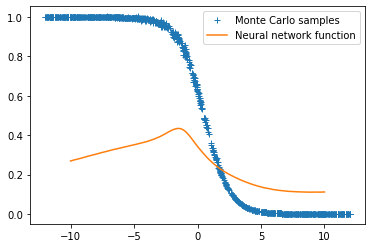

Patch 0: epoch 0 with loss 0.8272731900215149


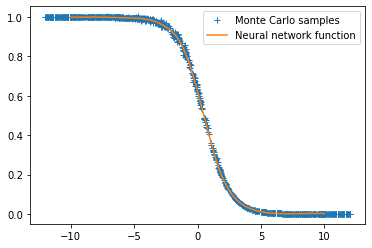

Patch 0: epoch 500 with loss 2.5268040189985186e-05


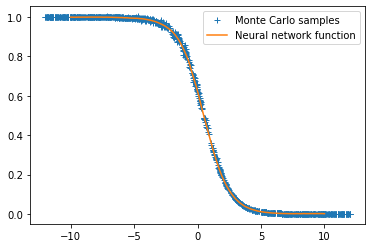

Patch 0: epoch 1000 with loss 2.38589145737933e-05


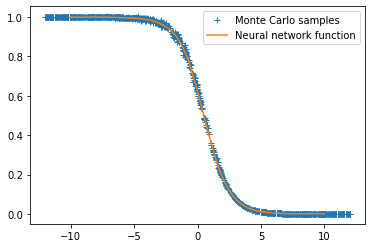

Patch 0: epoch 1500 with loss 2.3884185793576762e-05


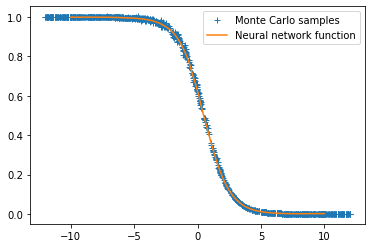

Patch 0: epoch 2000 with loss 2.3889158910606056e-05


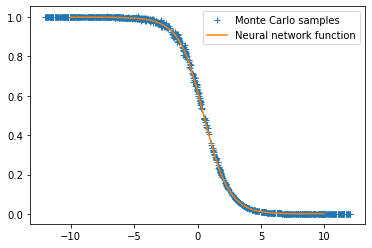

Patch 0: epoch 2500 with loss 2.390200097579509e-05


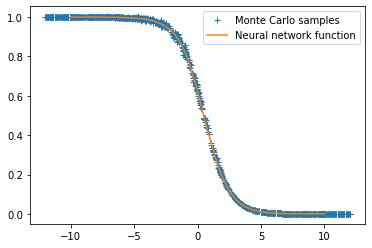

Patch 0: epoch 2999 with loss 2.4160097382264212e-05
Patch 0: training of neural network with 3000 epochs take 10.216938018798828 seconds.
Time taken: 55 seconds; L1 error: 1.00E-03; L2 error: 3.01E-06; rel error: 5.05E-01.
fdb runtime: 0 seconds; total runtime: 55 seconds.




######## Summary for deep branching method
runtime:        55
fdb runtime:    0
total runtime:  55
mean L1 error:  1.00E-03
std L1 error:   0.00E+00
mean L2 error:  3.01E-06
std L2 error:   0.00E+00
mean rel error: 5.05E-01
std rel error:  0.00E+00


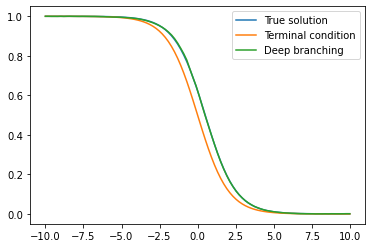

In [4]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="burger", nu=nu,
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

# Extended Burgers equation with n=2 (Dongming)

$$
\partial_t u + 2\nu \partial_{xx} u |\partial_{x} u| - u \partial_x u = 0
$$
admits the closed-form solution
$$
u(t,x) = u_1 + (u_2 - u_1)\left(1 + \sin^2\left(\frac{(x-\lambda (T-t))}{2\sqrt{2\nu}}\right)\right)^{-1},
$$
where $\lambda = (u_1 + u_2)/2$.

## T=.5

In [138]:
nu, u1, u2 = .5, 0., 5.
lambd = (u1 + u2) / 2
nu_for_delta = nu

# function definition
deriv_map = np.array([0, 1, 2]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return - y[0] * y[1] + 2 * nu * y[2] * y[1].abs() - nu_for_delta * y[2]

def phi_example(x):
    return u1 + (u2 - u1) / (1 + torch.sin(x[0] / (2 * math.sqrt(2 * nu)))**2)

def exact_example(t, x, T):
    xi = x[0] - lambd * (T - t)
    return u1 + (u2 - u1) / (1 + np.sin(xi / (2 * math.sqrt(2 * nu)))**2)

t_lo, x_lo, x_hi = 0., -10., 10.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .1
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 11.045830011367798 seconds.


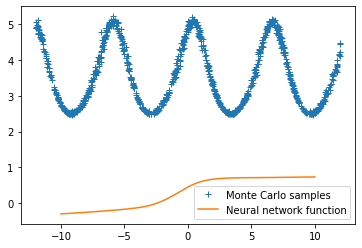

Patch 0: epoch 0 with loss 14.309592247009277


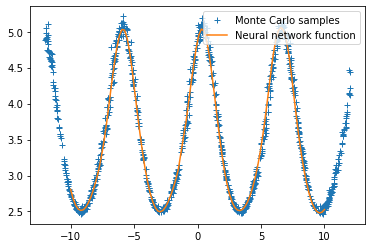

Patch 0: epoch 500 with loss 0.004932433366775513


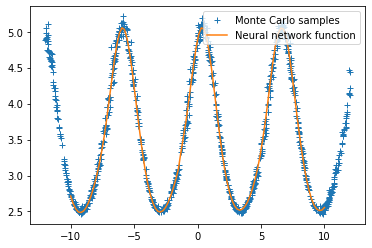

Patch 0: epoch 1000 with loss 0.005013766698539257


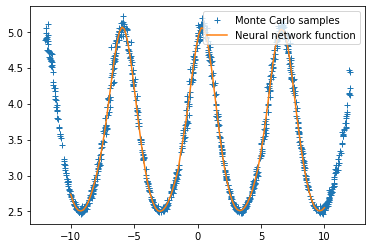

Patch 0: epoch 1500 with loss 0.0047246250323951244


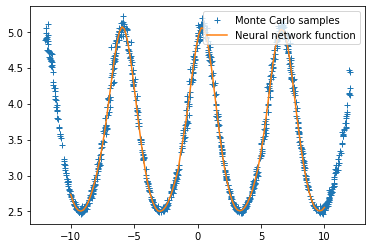

Patch 0: epoch 2000 with loss 0.004716419614851475


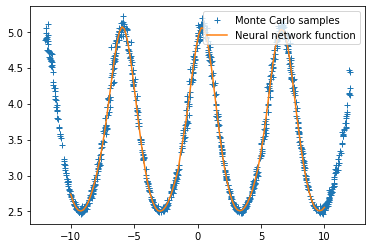

Patch 0: epoch 2500 with loss 0.00470910407602787


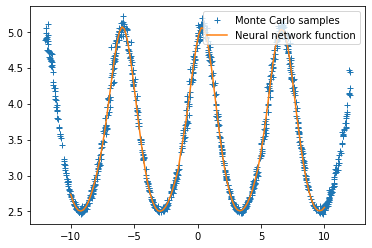

Patch 0: epoch 2999 with loss 0.004710903391242027
Patch 0: training of neural network with 3000 epochs take 10.68991231918335 seconds.
Time taken: 22 seconds; L1 error: 6.47E-02; L2 error: 8.31E-03; rel error: 1.70E-02.
fdb runtime: 0 seconds; total runtime: 22 seconds.




######## Summary for deep branching method
runtime:        22
fdb runtime:    0
total runtime:  22
mean L1 error:  6.47E-02
std L1 error:   0.00E+00
mean L2 error:  8.31E-03
std L2 error:   0.00E+00
mean rel error: 1.70E-02
std rel error:  0.00E+00


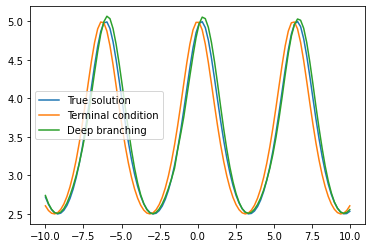

In [83]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="burger", nu=nu_for_delta,
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200, outlier_multiplier=100,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 96.02608847618103 seconds.


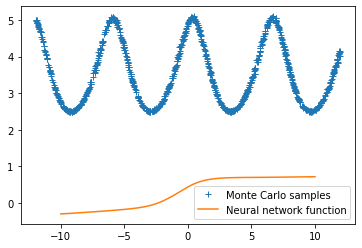

Patch 0: epoch 0 with loss 14.188237190246582


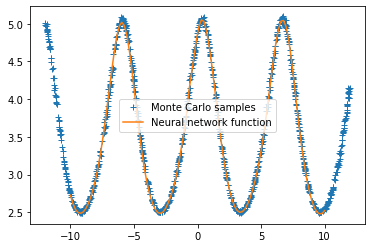

Patch 0: epoch 500 with loss 0.0010666870512068272


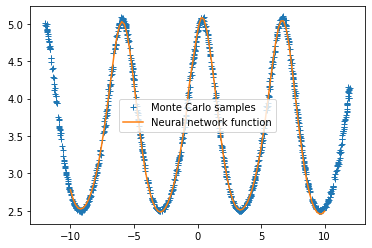

Patch 0: epoch 1000 with loss 0.0022202429827302694


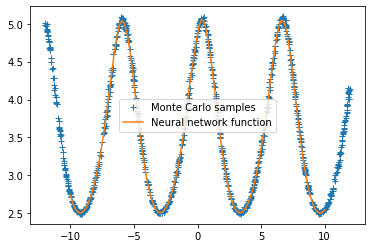

Patch 0: epoch 1500 with loss 0.0009119176538661122


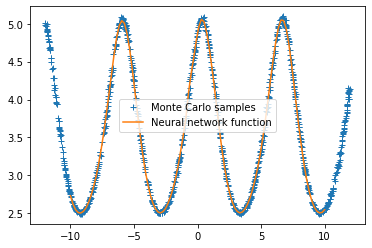

Patch 0: epoch 2000 with loss 0.0009098766022361815


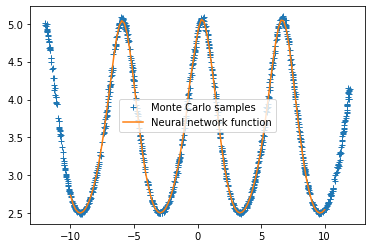

Patch 0: epoch 2500 with loss 0.0009112033294513822


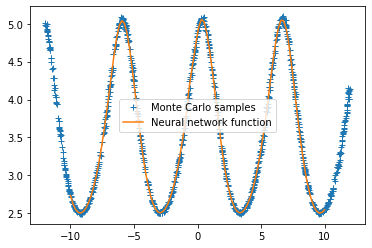

Patch 0: epoch 2999 with loss 0.0009123283089138567
Patch 0: training of neural network with 3000 epochs take 10.515372037887573 seconds.
Time taken: 107 seconds; L1 error: 6.10E-02; L2 error: 7.43E-03; rel error: 1.59E-02.
fdb runtime: 0 seconds; total runtime: 107 seconds.




######## Summary for deep branching method
runtime:        107
fdb runtime:    0
total runtime:  107
mean L1 error:  6.10E-02
std L1 error:   0.00E+00
mean L2 error:  7.43E-03
std L2 error:   0.00E+00
mean rel error: 1.59E-02
std rel error:  0.00E+00


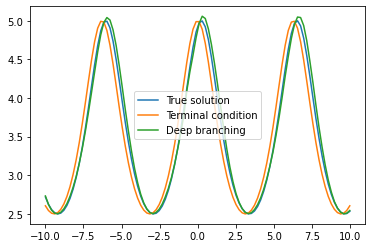

In [139]:
# Performance comparison, increase nb_path_per_state -> not better
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="burger", nu=nu_for_delta,
                    branch_nb_states=1000, branch_nb_path_per_state=50000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200, outlier_multiplier=100,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

# Extended Burgers equation with n=1/2 (Dongming)

$$
\partial_t u + \frac{1}{2} \nu \partial_{xx} u (\partial_x u)^2 / |\partial_{x} u|^{5/2}= 0
$$
admits the closed-form solution
$$
u(t, x) = f^{-1}(\xi),
$$
where
$f(u) 
= (2\nu)^2
\left(
(u_2 - u_1)^{-2}
\left(\frac{1}{u_2 - u} - \frac{1}{u - u_1}\right)
- \frac{2}{(u_1 - u_2)^3} \log\left(\frac{u_2 - u}{u - u_1}\right)
\right),
$
$\lambda = (u_1 + u_2)/2$
and
$\xi = x - \lambda (T-t)$.

## T=.01

Epoch 0, loss = 107.55870056152344
Epoch 100, loss = 0.021543027833104134
Epoch 200, loss = 0.0004322977038100362
Epoch 300, loss = 0.0006163212237879634
Epoch 400, loss = 0.00041247246554121375
Epoch 500, loss = 0.0005559497512876987
Epoch 600, loss = 0.002094636205583811
Epoch 700, loss = 0.0002302958891959861
Epoch 800, loss = 0.00020629374193958938
Epoch 900, loss = 0.0003102921473328024
Epoch 1000, loss = 0.0001582849508849904
Epoch 1100, loss = 0.0003443840832915157
Epoch 1200, loss = 0.00027633970603346825
Epoch 1300, loss = 0.0002910022158175707
Epoch 1400, loss = 0.0003897974092978984
Epoch 1500, loss = 0.0001864409859990701
Epoch 1600, loss = 0.0007642796263098717
Epoch 1700, loss = 0.00011909355816897005
Epoch 1800, loss = 0.0001550660381326452
Epoch 1900, loss = 0.0003116294974461198
Epoch 2000, loss = 0.00035480959923006594
Epoch 2100, loss = 0.002050172071903944
Epoch 2200, loss = 0.0014890586026012897
Epoch 2300, loss = 0.00031146276160143316
Epoch 2400, loss = 0.0001951

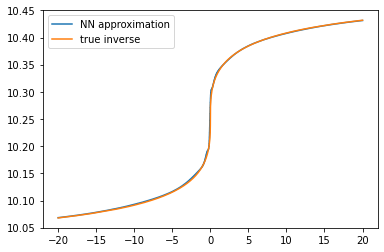

In [142]:
from pynverse import inversefunc

# neural network approximation of the inverse function
nu, u1, u2 = .5, 10., 10.5
lambd = (u1 + u2) / 2
neurons = 50

# neural network parameter
inv_model = torch.nn.Sequential(
    torch.nn.BatchNorm1d(1, device=device),
    torch.nn.Linear(1, neurons, device=device),
    torch.nn.Tanh(),
    torch.nn.BatchNorm1d(neurons, device=device),
    torch.nn.Linear(neurons, neurons, device=device),
    torch.nn.Tanh(),
    torch.nn.BatchNorm1d(neurons, device=device),
    torch.nn.Linear(neurons, neurons, device=device),
    torch.nn.Tanh(),
    torch.nn.BatchNorm1d(neurons, device=device),
    torch.nn.Linear(neurons, neurons, device=device),
    torch.nn.Tanh(),
    torch.nn.BatchNorm1d(neurons, device=device),
    torch.nn.Linear(neurons, neurons, device=device),
    torch.nn.Tanh(),
    torch.nn.BatchNorm1d(neurons, device=device),
    torch.nn.Linear(neurons, 1, device=device),
)

# define the functions, x, and y
fun = (lambda u: (2*nu)**2*((u2-u1)**(-2)*(1/(u2-u)-1/(u-u1))-2*np.log((u2-u)/(u-u1))/(u1-u2)**3))
torch_fun = (lambda u: (2*nu)**2*((u2-u1)**(-2)*(1/(u2-u)-1/(u-u1))-2*torch.log((u2-u)/(u-u1))/(u1-u2)**3))
inv = (lambda xi: inversefunc(fun, y_values=xi, domain=[u1+0.00001,u2-0.00001]))
nb_points = 10000

# neural network training
optimizer = torch.optim.Adam(inv_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2000, 4000, 6000, 8000], gamma=0.5)
loss_fun = torch.nn.MSELoss()  # torch.nn.L1Loss()
inv_model.train()
for epoch in range(10000):
    optimizer.zero_grad()
#     loss = loss_fun(y, inv_model(x).squeeze())
    if epoch % 100 == 0:
        x = u1 + (u2 - u1) * torch.rand(nb_points, 1, device=device)
    loss = loss_fun(x, inv_model(torch_fun(x)))
    loss.backward()
    optimizer.step()
    scheduler.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, loss = {loss}")
inv_model.eval()

# detach all model parameters to save memory
for p in inv_model.parameters():
    p.requires_grad = False

# plot the graph
x = np.linspace(-20, 20, nb_points)
y = torch.tensor(inv(x), dtype=torch.get_default_dtype(), device=device)
x = torch.tensor(x, dtype=torch.get_default_dtype(), device=device).unsqueeze(dim=-1)
plt.plot(x.cpu(), inv_model(x).detach().cpu(), label="NN approximation")
plt.plot(x.cpu(), y.cpu(), label="true inverse")
plt.legend()

print(f"The max difference is {(y.cpu() - inv_model(x).detach().cpu().squeeze()).abs().max()}.")

In [143]:
nu_for_delta = nu

# function definition
deriv_map = np.array([0, 1, 2]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return (
        - y[0] * y[1]
        + .5 * nu * y[2] * y[1].square() / (y[1].abs().sqrt()**5) 
        - nu_for_delta * y[2]
    )

def phi_example(x):
    return inv_model(x.T).squeeze(dim=-1)

def exact_example(t, x, T):
    xi = x[0] - lambd * (T - t)
    return inv(xi)

t_lo, x_lo, x_hi = 0., -10., 10.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .1
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 27.748476266860962 seconds.


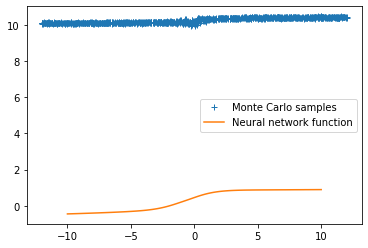

Patch 0: epoch 0 with loss 106.61420440673828


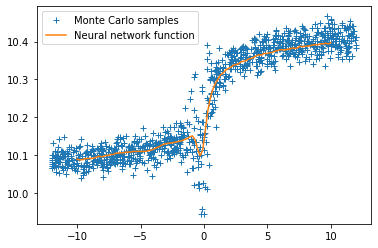

Patch 0: epoch 500 with loss 0.0011282871710136533


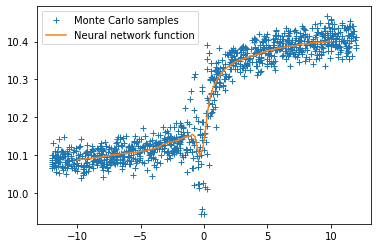

Patch 0: epoch 1000 with loss 0.0011246787616983056


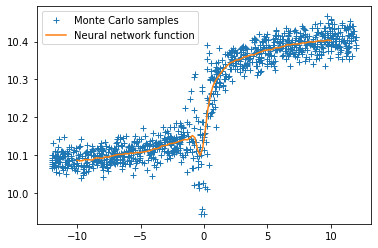

Patch 0: epoch 1500 with loss 0.0011232926044613123


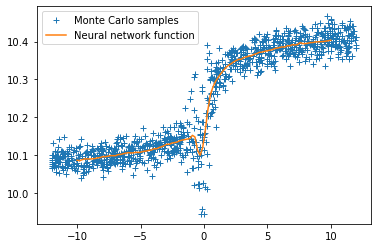

Patch 0: epoch 2000 with loss 0.0011200597509741783


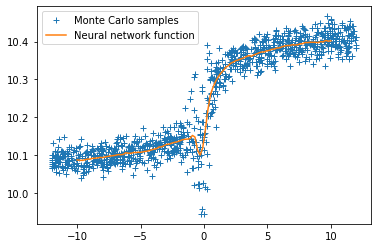

Patch 0: epoch 2500 with loss 0.001119603868573904


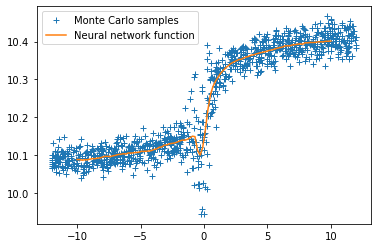

Patch 0: epoch 2999 with loss 0.0011206874623894691
Patch 0: training of neural network with 3000 epochs take 10.186679363250732 seconds.
Time taken: 38 seconds; L1 error: 6.17E-03; L2 error: 3.17E-04; rel error: 6.06E-04.
fdb runtime: 0 seconds; total runtime: 38 seconds.




######## Summary for deep branching method
runtime:        38
fdb runtime:    0
total runtime:  38
mean L1 error:  6.17E-03
std L1 error:   0.00E+00
mean L2 error:  3.17E-04
std L2 error:   0.00E+00
mean rel error: 6.06E-04
std rel error:  0.00E+00


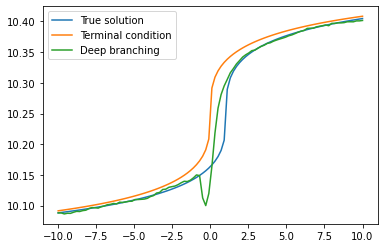

In [144]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="burger", nu=nu_for_delta,
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=100, outlier_multiplier=100,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 110.73023104667664 seconds.


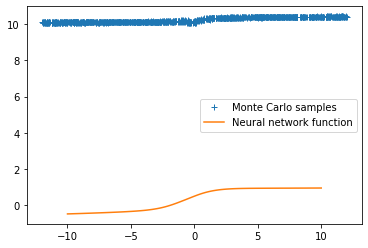

Patch 0: epoch 0 with loss 106.34666442871094


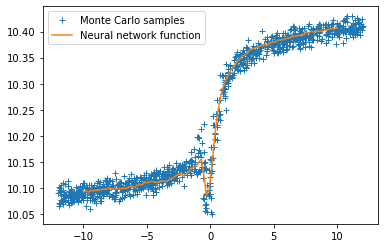

Patch 0: epoch 500 with loss 0.0002380643563810736


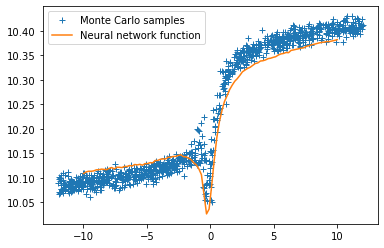

Patch 0: epoch 1000 with loss 0.0008229687809944153


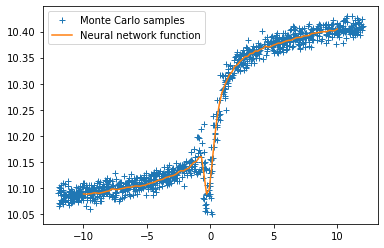

Patch 0: epoch 1500 with loss 0.00019375528790988028


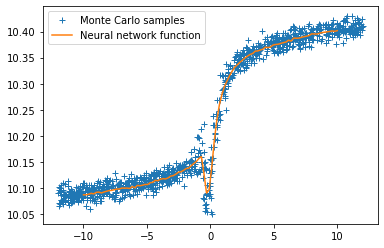

Patch 0: epoch 2000 with loss 0.0001923530944623053


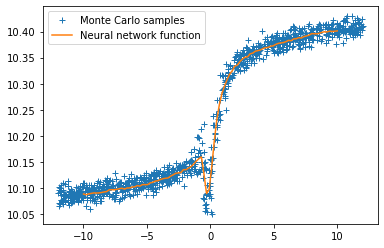

Patch 0: epoch 2500 with loss 0.00019440148025751114


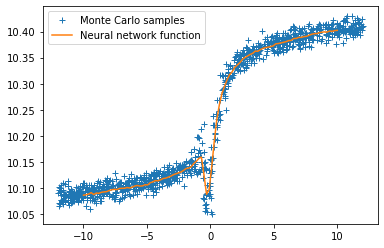

Patch 0: epoch 2999 with loss 0.00019381749734748155
Patch 0: training of neural network with 3000 epochs take 10.21452260017395 seconds.
Time taken: 121 seconds; L1 error: 5.89E-03; L2 error: 2.44E-04; rel error: 5.78E-04.
fdb runtime: 0 seconds; total runtime: 121 seconds.




######## Summary for deep branching method
runtime:        121
fdb runtime:    0
total runtime:  121
mean L1 error:  5.89E-03
std L1 error:   0.00E+00
mean L2 error:  2.44E-04
std L2 error:   0.00E+00
mean rel error: 5.78E-04
std rel error:  0.00E+00


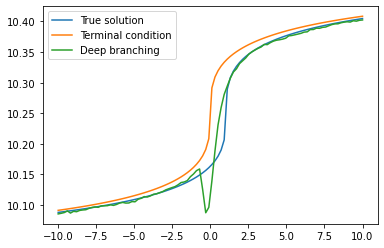

In [145]:
# Performance comparison, increase nb_path_per_state -> not better
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="burger", nu=nu_for_delta,
                    branch_nb_states=1000, branch_nb_path_per_state=50000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=100, outlier_multiplier=100,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

# Burgers-type equation (Weinan)

$$
\partial_t u + \frac{1}{2} \partial_{xx} u + (u-\frac{3}{2}) \partial_x u = 0
$$
with
$$
\phi(x) = 1 - (1 + \exp(T+x))^{-1}
$$
admits the solution
$$
u(t,x) = 1 - (1 + \exp(t+x))^{-1}.
$$

## T=1

In [17]:
T = 1.
# function definition
deriv_map = np.array([0, 1]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    """
    return (y[0] - 3/2) * y[1]

def phi_example(x):
    return 1 - 1/(1 + torch.exp(T + x[0]))

def exact_example(t, x, T):
    return 1 - 1/(1 + np.exp(t + x[0]))

t_lo, x_lo, x_hi = 0., -10., 10.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 42.0458984375 seconds.


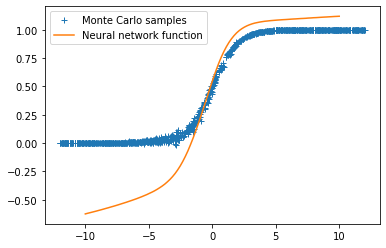

Patch 0: epoch 0 with loss 1.020080804824829


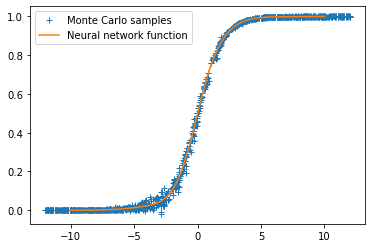

Patch 0: epoch 500 with loss 0.00011563530279090628


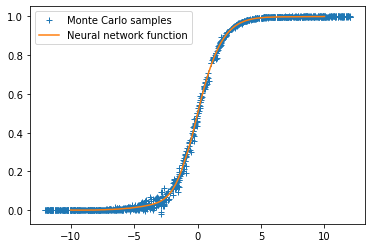

Patch 0: epoch 1000 with loss 0.00011465713032521307


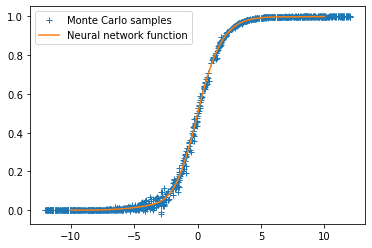

Patch 0: epoch 1500 with loss 0.00011441430979175493


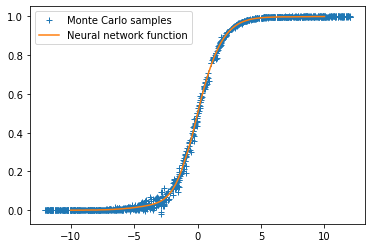

Patch 0: epoch 2000 with loss 0.00011429719597799703


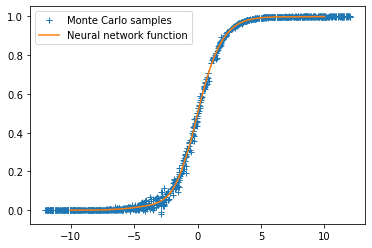

Patch 0: epoch 2500 with loss 0.00011435774649726227


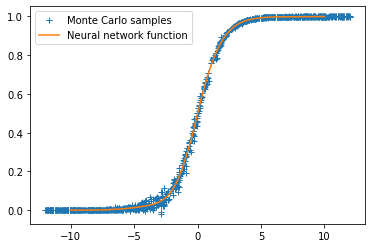

Patch 0: epoch 2999 with loss 0.00011422739044064656
Patch 0: training of neural network with 3000 epochs take 10.273178339004517 seconds.
Time taken: 52 seconds; L1 error: 3.20E-03; L2 error: 2.99E-05; rel error: 5.75E-01.
fdb runtime: 0 seconds; total runtime: 52 seconds.




######## Summary for deep branching method
runtime:        52
fdb runtime:    0
total runtime:  52
mean L1 error:  3.20E-03
std L1 error:   0.00E+00
mean L2 error:  2.99E-05
std L2 error:   0.00E+00
mean rel error: 5.75E-01
std rel error:  0.00E+00


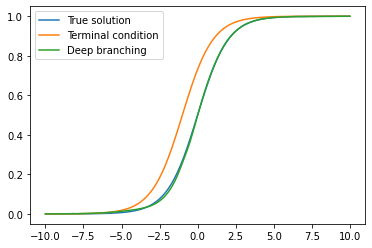

In [18]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="burger",
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

# Kuramoto-Sivashinsky equation - example 1

## T=.2 with nu=alpha

In [59]:
alpha, beta, gamma = 1, 4, 1
T = .2

# function definition
deriv_map = np.array([0, 1, 3, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> third deriv
    idx 3 -> forth deriv
    """
    return y[0] * y[1] + beta * y[2] + gamma * y[3]

def phi_example(x):
    theta = -.5 * x[0]
    return (
        11
        + 15 * torch.tanh(theta)
        - 15 * (torch.tanh(theta))**2
        - 15 * (torch.tanh(theta))**3
    )

def exact_example(t, x, T):
    theta = -.5 * x[0] - (T - t)
    return (
        11
        + 15 * np.tanh(theta)
        - 15 * (np.tanh(theta))**2
        - 15 * (np.tanh(theta))**3
    )

t_lo, x_lo, x_hi = 0., -10., 10.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 41.03263235092163 seconds.


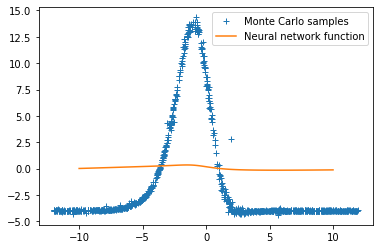

Patch 0: epoch 0 with loss 27.276123046875


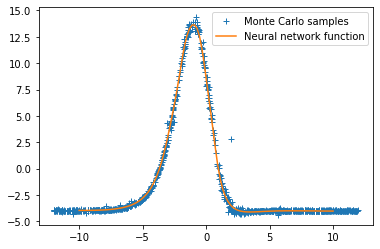

Patch 0: epoch 500 with loss 0.07269259542226791


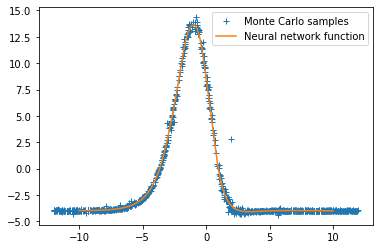

Patch 0: epoch 1000 with loss 0.0724671483039856


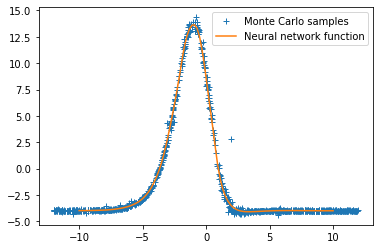

Patch 0: epoch 1500 with loss 0.07237877696752548


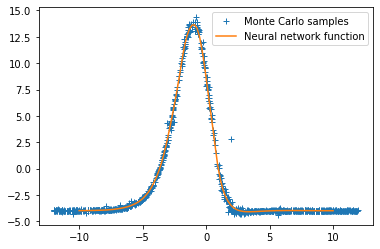

Patch 0: epoch 2000 with loss 0.07242176681756973


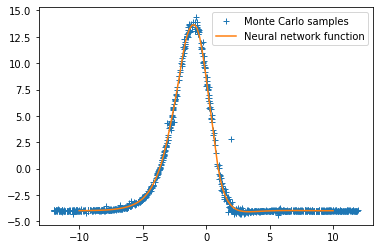

Patch 0: epoch 2500 with loss 0.07243341952562332


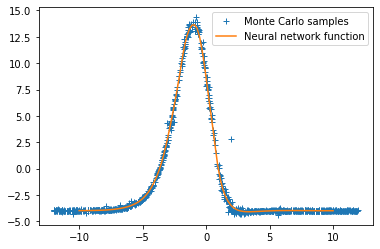

Patch 0: epoch 2999 with loss 0.07243332266807556
Patch 0: training of neural network with 3000 epochs take 10.408766508102417 seconds.
Time taken: 51 seconds; L1 error: 1.46E-01; L2 error: 8.13E-02; rel error: 4.81E-02.
fdb runtime: 0 seconds; total runtime: 51 seconds.




######## Summary for deep branching method
runtime:        51
fdb runtime:    0
total runtime:  51
mean L1 error:  1.46E-01
std L1 error:   0.00E+00
mean L2 error:  8.13E-02
std L2 error:   0.00E+00
mean rel error: 4.81E-02
std rel error:  0.00E+00


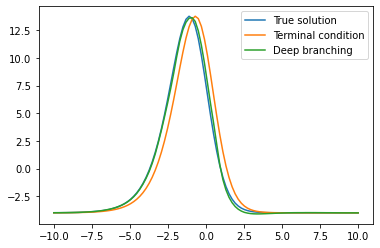

In [60]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="kuramoto-sivashinsky", nu=alpha,
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200, outlier_multiplier=100,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

## T=.5

In [11]:
T = .5
def phi_example(x):
    theta = -.5 * x[0] + T
    return (
        11
        + 15 * torch.tanh(theta)
        - 15 * (torch.tanh(theta))**2
        - 15 * (torch.tanh(theta))**3
    )

true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 447.3950219154358 seconds.


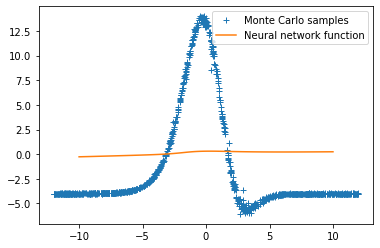

Patch 0: epoch 0 with loss 33.16690444946289


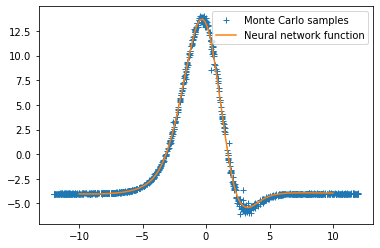

Patch 0: epoch 500 with loss 0.036735087633132935


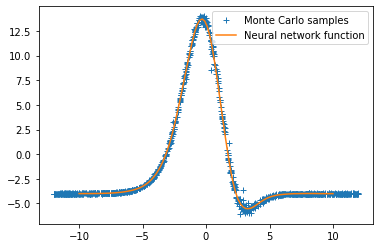

Patch 0: epoch 1000 with loss 0.03583857789635658


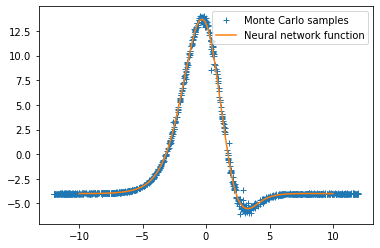

Patch 0: epoch 1500 with loss 0.035789214074611664


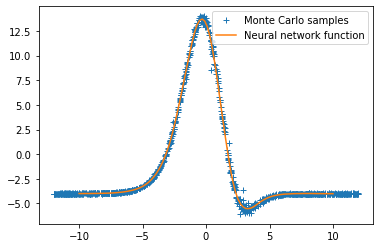

Patch 0: epoch 2000 with loss 0.03577928617596626


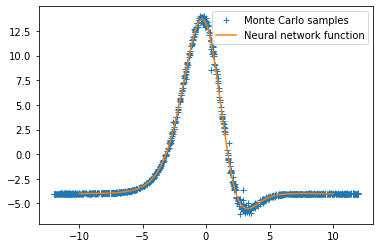

Patch 0: epoch 2500 with loss 0.035782840102910995


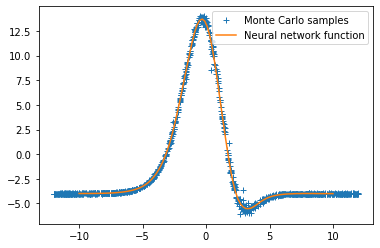

Patch 0: epoch 2999 with loss 0.035765182226896286
Patch 0: training of neural network with 3000 epochs take 10.047555208206177 seconds.
Time taken: 457 seconds; L1 error: 6.75E-01; L2 error: 1.54E+00; rel error: 3.59E-01.
fdb runtime: 1 seconds; total runtime: 457 seconds.




######## Summary for deep branching method
runtime:        457
fdb runtime:    1
total runtime:  457
mean L1 error:  6.75E-01
std L1 error:   0.00E+00
mean L2 error:  1.54E+00
std L2 error:   0.00E+00
mean rel error: 3.59E-01
std rel error:  0.00E+00


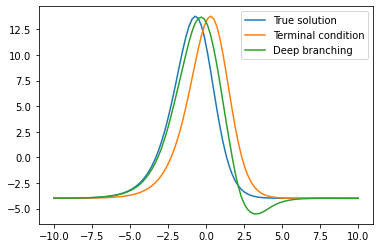

In [14]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="kuramoto-sivashinsky", nu=alpha,
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=10, outlier_multiplier=100,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

# Kuramoto-Sivashinsky equation - example 3

## T=.5

In [24]:
alpha, beta, gamma = 1, .0, .5

# function definition
deriv_map = np.array([0, 1, 2, 3, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    idx 3 -> third deriv
    idx 4 -> forth deriv
    """
    return -y[0] * y[1] - (alpha + .5) * y[2]- beta * y[3] - gamma * y[4]

def phi_example(x):
    kappa = .5 * math.sqrt(11 * alpha / (19 * gamma))
    theta = kappa * x[0]
    return (
        -0.1 / kappa 
        + 60 / 19 * kappa * (-38 * gamma * kappa**2 + alpha) * torch.tanh(theta) 
        + 120 * gamma * kappa**3 * (torch.tanh(theta))**3
    )

def exact_example(t, x, T):
    kappa = .5 * math.sqrt(11 * alpha / (19 * gamma))
    theta = kappa * x[0] + .1 * (T - t)
    return (
        -0.1 / kappa 
        + 60 / 19 * kappa * (-38 * gamma * kappa**2 + alpha) * np.tanh(theta) 
        + 120 * gamma * kappa**3 * (np.tanh(theta))**3
    )

t_lo, x_lo, x_hi = 0., -10., 10.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 136.49761033058167 seconds.


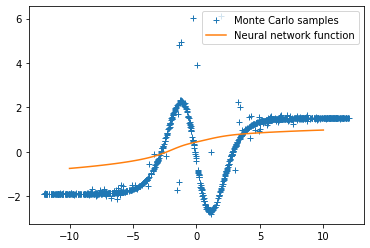

Patch 0: epoch 0 with loss 2.9177589416503906


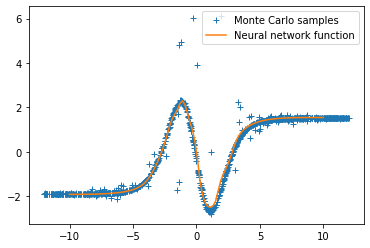

Patch 0: epoch 500 with loss 0.15935806930065155


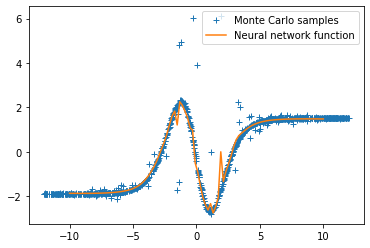

Patch 0: epoch 1000 with loss 0.13473479449748993


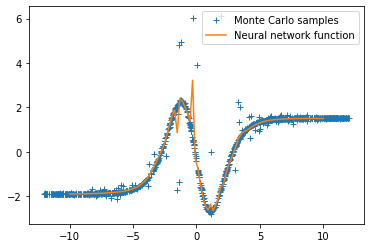

Patch 0: epoch 1500 with loss 0.1095966249704361


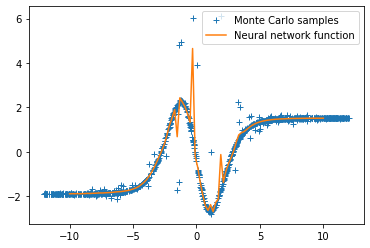

Patch 0: epoch 2000 with loss 0.08885902911424637


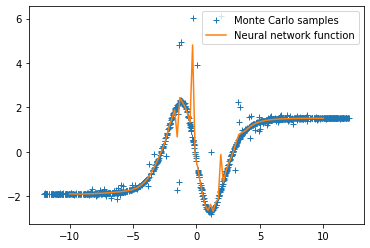

Patch 0: epoch 2500 with loss 0.08710905909538269


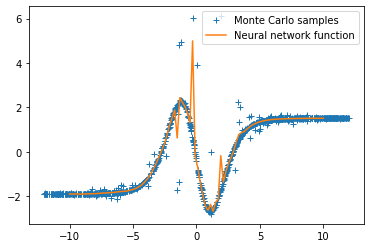

Patch 0: epoch 2999 with loss 0.0854891836643219
Patch 0: training of neural network with 3000 epochs take 10.407729148864746 seconds.
Time taken: 146 seconds; L1 error: 1.22E-01; L2 error: 2.44E-01; rel error: 1.45E-01.
fdb runtime: 1 seconds; total runtime: 147 seconds.




######## Summary for deep branching method
runtime:        146
fdb runtime:    1
total runtime:  147
mean L1 error:  1.22E-01
std L1 error:   0.00E+00
mean L2 error:  2.44E-01
std L2 error:   0.00E+00
mean rel error: 1.45E-01
std rel error:  0.00E+00


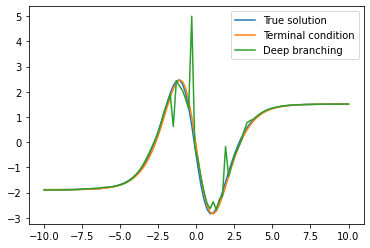

In [25]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="kuramoto-sivashinsky",
                    branch_nb_states=1000, branch_nb_path_per_state=5000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

## T=.05

In [34]:
alpha, beta, gamma = 1, .0, .5

# function definition
deriv_map = np.array([0, 1, 2, 3, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    idx 3 -> third deriv
    idx 4 -> forth deriv
    """
    return -y[0] * y[1] - (alpha + .5) * y[2]- beta * y[3] - gamma * y[4]

def phi_example(x):
    kappa = .5 * math.sqrt(11 * alpha / (19 * gamma))
    theta = kappa * x[0]
    return (
        -0.1 / kappa 
        + 60 / 19 * kappa * (-38 * gamma * kappa**2 + alpha) * torch.tanh(theta) 
        + 120 * gamma * kappa**3 * (torch.tanh(theta))**3
    )

def exact_example(t, x, T):
    kappa = .5 * math.sqrt(11 * alpha / (19 * gamma))
    theta = kappa * x[0] + .1 * (T - t)
    return (
        -0.1 / kappa 
        + 60 / 19 * kappa * (-38 * gamma * kappa**2 + alpha) * np.tanh(theta) 
        + 120 * gamma * kappa**3 * (np.tanh(theta))**3
    )

t_lo, x_lo, x_hi = 0., -10., 10.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .05
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 136.52296376228333 seconds.


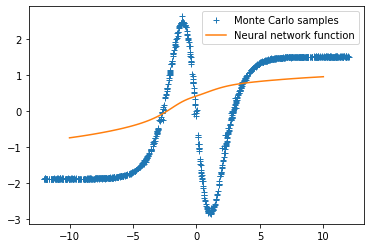

Patch 0: epoch 0 with loss 2.851299524307251


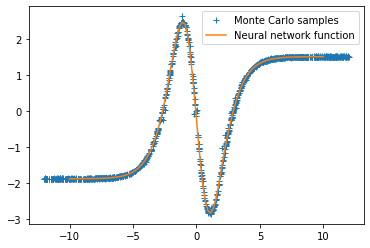

Patch 0: epoch 500 with loss 0.0015764092095196247


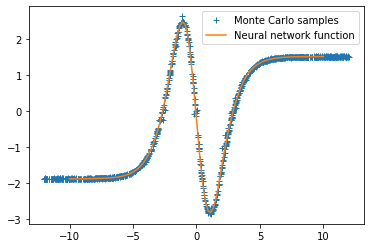

Patch 0: epoch 1000 with loss 0.00160446937661618


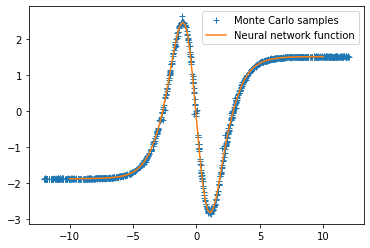

Patch 0: epoch 1500 with loss 0.0015611343551427126


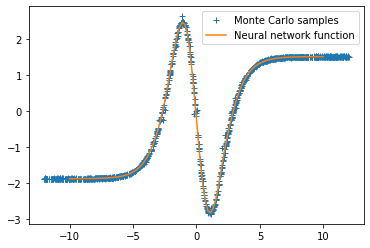

Patch 0: epoch 2000 with loss 0.0015597001183778048


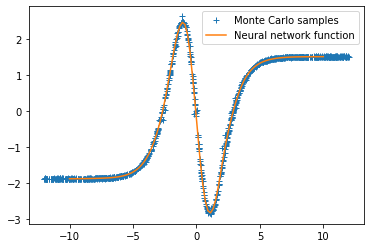

Patch 0: epoch 2500 with loss 0.001561193959787488


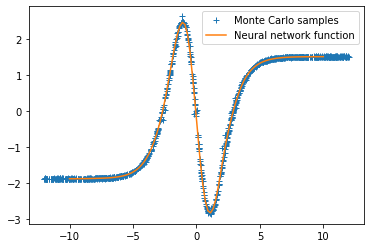

Patch 0: epoch 2999 with loss 0.0015582123305648565
Patch 0: training of neural network with 3000 epochs take 10.417350769042969 seconds.
Time taken: 146 seconds; L1 error: 6.12E-03; L2 error: 1.72E-04; rel error: 8.64E-03.
fdb runtime: 1 seconds; total runtime: 147 seconds.




######## Summary for deep branching method
runtime:        146
fdb runtime:    1
total runtime:  147
mean L1 error:  6.12E-03
std L1 error:   0.00E+00
mean L2 error:  1.72E-04
std L2 error:   0.00E+00
mean rel error: 8.64E-03
std rel error:  0.00E+00


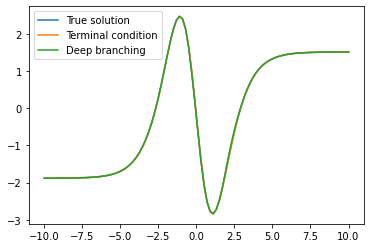

In [35]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="kuramoto-sivashinsky",
                    branch_nb_states=1000, branch_nb_path_per_state=5000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

# Gradient of 1-dimensional Allen-Cahn

In [36]:
# function definition
deriv_map = np.array([0]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

dgm_deriv_map = np.array([0, 2]).reshape(-1, 1)
def dgm_f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> second deriv
    """
    return .5 * y[1] + y[0] - y[0] ** 3

def phi_example(x):
    return -0.5 - 0.5 * torch.nn.Tanh()(-x[0] / 2)

def exact_example(t, x, T):
    return 0.25 * (1 - np.tanh(-x[0]/2 + 3*(T-t)/4)**2)

t_lo, x_lo, x_hi, n = 0., -8., 8., 0
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 10.396223068237305 seconds.


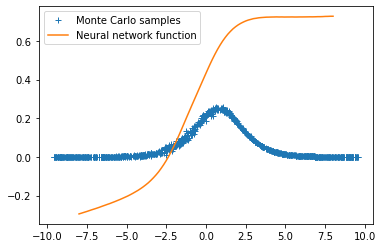

Patch 0: epoch 0 with loss 0.3921620547771454


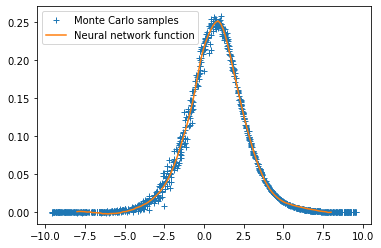

Patch 0: epoch 500 with loss 2.3328673705691472e-05


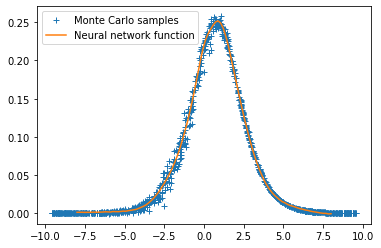

Patch 0: epoch 1000 with loss 2.2917927708476782e-05


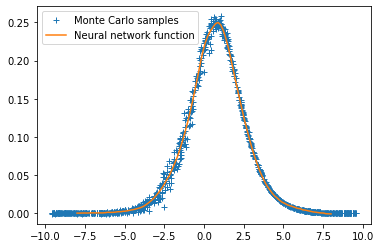

Patch 0: epoch 1500 with loss 2.197835965489503e-05


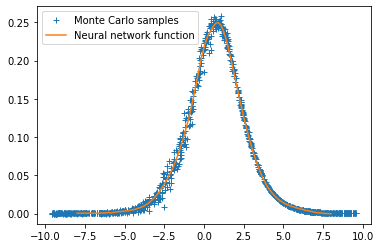

Patch 0: epoch 2000 with loss 2.1880918211536482e-05


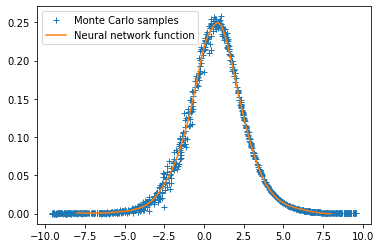

Patch 0: epoch 2500 with loss 2.1962900063954294e-05


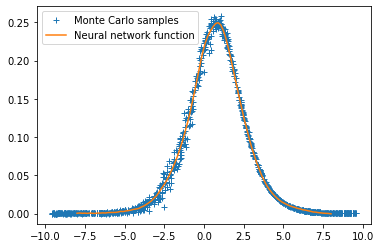

Patch 0: epoch 2999 with loss 2.1890014977543615e-05
Patch 0: training of neural network with 3000 epochs take 10.450318098068237 seconds.
Time taken: 21 seconds; L1 error: 9.34E-04; L2 error: 2.07E-06; rel error: 1.65E-01.
fdb runtime: 0 seconds; total runtime: 21 seconds.




######## Summary for deep branching method
runtime:        21
fdb runtime:    0
total runtime:  21
mean L1 error:  9.34E-04
std L1 error:   0.00E+00
mean L2 error:  2.07E-06
std L2 error:   0.00E+00
mean rel error: 1.65E-01
std rel error:  0.00E+00


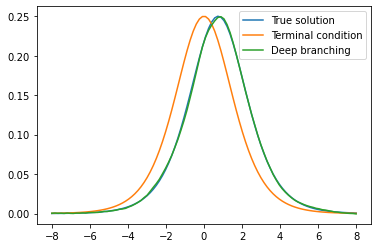

In [37]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn", code=[-2],
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)